We will train two different models. One cnn will use the written digit training data to predict the label, while the other, an rnn, will use the spoken audio data to do the same. To make our final predictions, we will use the model which exhibits the highest confidence for each guess. We will procede first by training the cnn: 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

<Axes: >

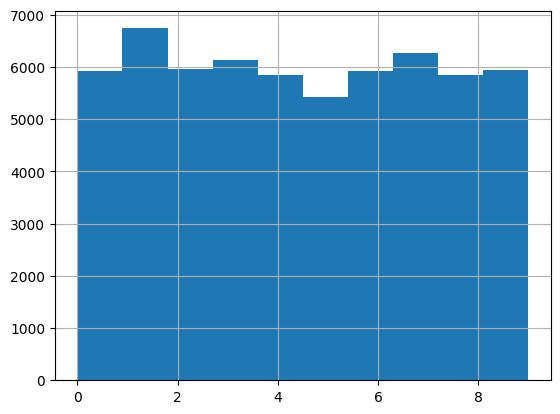

In [6]:
#get labels, explore distribution
training_labels = pd.read_csv("data/y_train.csv")["label"]
training_labels.hist()

In [7]:
#custom dataset wrapper
class CustomDataset(Dataset):
    def __init__(self, data_file, labels_file=None, is_test=False):
        self.data = np.load(data_file)
        if not is_test:
            self.labels = pd.read_csv(labels_file)["label"]
        else:
            self.labels = None
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            sample = {
                'data': torch.tensor(self.data[idx].reshape(1, 28, 28), dtype=torch.float),
                'label': torch.tensor(self.labels[idx], dtype=torch.long)
            }
        else:
            sample = {
                'data': torch.tensor(self.data[idx].reshape(1, 28, 28), dtype=torch.float)
            }
        return sample


def get_data_loaders(data_file, labels_file, batch_size=64, validation_size=0.2):
    dataset = CustomDataset(data_file, labels_file)
    
    #split dataset into training and validation sets
    train_indices, val_indices = train_test_split(
        np.arange(len(dataset)),
        test_size=validation_size,
        random_state=21,
        stratify=dataset.labels  
    )
    
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_indices)
    )
    
    val_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_indices)
    )
    
    return train_loader, val_loader

In [8]:
img_dataset = CustomDataset("data/x_train_wr.npy", "data/y_train.csv")

In [9]:
#custom cnn implementation
#CNN implementation

class cnn_block(nn.Module):
  def __init__(self, in_channels = 3, n_hidden = 5, kernel_size = (2, 2)):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels       = in_channels, out_channels = n_hidden, kernel_size = kernel_size, bias=False, padding = 'same'),
        nn.BatchNorm2d(num_features = n_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Conv2d(in_channels       = n_hidden, out_channels = in_channels, kernel_size = kernel_size, bias=False, padding = 'same'),
        nn.BatchNorm2d(num_features = in_channels),
        nn.ReLU(),
        nn.Dropout(p=0.2))

  def forward(self, x):
    return x + self.layers(x)


class linear_block(nn.Module):
  def __init__(self, in_features, n_hidden):
    super().__init__()
    self.in_features = (in_features, n_hidden)
    self.layers = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = n_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features = n_hidden, out_features = in_features),
        nn.ReLU()
    )

  def forward(self, x):
    return x + self.layers(x)

class CNNClassifier(nn.Module):
  def __init__(self, in_channels = 1, cnn_channels = 1, linear_hidden = 500, n_classes = 10, kernel_size = (3, 3)):
    super().__init__()

    
    self.cnn_layers = nn.Sequential(
        cnn_block(in_channels, cnn_channels, kernel_size),
        cnn_block(in_channels, cnn_channels, kernel_size),
        cnn_block(in_channels, cnn_channels, kernel_size))


    self.down_sample = nn.Conv2d(in_channels = in_channels, out_channels = 1, kernel_size = (1, 1))

    self.linear_layers = nn.Sequential(
        linear_block(28*28, linear_hidden),
        linear_block(28*28, linear_hidden)
    )
    self.last_layer = nn.Linear(28*28, n_classes)

    self.all        = nn.Sequential(
        self.cnn_layers,
        self.down_sample,
        nn.Flatten(),
        self.linear_layers,
        self.last_layer,
    )

  def forward(self, x):
    return self.all(x)

In [10]:
#train cnn

#training 
def train_cnn(model, train_loader, val_loader, optimizer, criterion, epochs=5, device='cpu'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/ {epochs}", unit="batch"):
            inputs, labels = batch['data'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch['data'].to(device), batch['label'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}")


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def validate(model, val_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['data'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    f1 = f1_score(true_labels, predicted_labels, average='macro')
    return f1

In [12]:
#split the data into training and validation sets with 80-20 split
batch_size = 64
validation_size = 0.2
train_loader, val_loader = get_data_loaders("data/x_train_wr.npy", "data/y_train.csv", batch_size=batch_size, validation_size=validation_size)

The next portion of the code tries out different hyperparams by training different models on a small subset of the training data (1/5 of the training data) for only 3 epochs. It takes a bit to run, but after expirementing, {'cnn_channels': 3, 'linear_hidden': 25, 'kernel_size': (5, 5)} TENDS to work the best (although other hyperparams are close) with an F1 score of roughly .94 (which is pretty good considering it's only training on a small subset of the total data). If you want to check my hyperparam comparision, you can simply change the variable below to True to run this process. Otherwise, we simply default to the previously described hyperparams.

In [13]:
waste_a_lot_of_time = True

In [14]:
#get a smaller dataset for hyperparam comparisons 
hyper_loader, hyper_val_loader = get_data_loaders("data/x_train_wr.npy", "data/y_train.csv", batch_size=batch_size, validation_size=.8) #thus we train on .2 of given data

In [15]:
#test different hyperparams 

hyperparameters = {
    'cnn_channels': [2, 3],  # Vary the number of channels in the CNN layers
    'linear_hidden': [25, 50],  # Vary the number of hidden units in linear layers
    'kernel_size': [(3, 3), (5, 5)]  # Vary the kernel size of the convolutional layers
}

# Perform hyperparameter tuning
best_f1 = 0.0
best_hyperparameters = {}
if (waste_a_lot_of_time):
    for cnn_channels in hyperparameters['cnn_channels']:
        for linear_hidden in hyperparameters['linear_hidden']:
            for kernel_size in hyperparameters['kernel_size']:
                print(f"Training model: cnn_channels={cnn_channels}, linear_hidden={linear_hidden}, kernel_size={kernel_size}")
                model = CNNClassifier(cnn_channels=cnn_channels, linear_hidden=linear_hidden, kernel_size=kernel_size)
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                criterion = nn.CrossEntropyLoss()
                train_cnn(model, hyper_loader, hyper_val_loader, optimizer, criterion, epochs=3)
                val_accuracy = validate(model, hyper_val_loader)
                print(f"Validation F1 for cnn_channels={cnn_channels}, linear_hidden={linear_hidden}, kernel_size={kernel_size}: {val_accuracy}")
                if val_accuracy > best_f1:
                    best_f1 = val_accuracy
                    best_hyperparameters = {'cnn_channels': cnn_channels, 'linear_hidden': linear_hidden, 'kernel_size': kernel_size}
else: 
    best_hyperparameters = {'cnn_channels': 3, 'linear_hidden': 25, 'kernel_size': (5, 5)}

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_f1)

Training model: cnn_channels=2, linear_hidden=25, kernel_size=(3, 3)


Epoch 1/ 3:   0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 1/ 3: 100%|██████████| 188/188 [00:07<00:00, 24.58batch/s]


Epoch 1/3, Train Loss: 0.7344, Train Accuracy: 0.7732, Validation Loss: 0.3110


Epoch 2/ 3: 100%|██████████| 188/188 [00:06<00:00, 29.45batch/s]


Epoch 2/3, Train Loss: 0.3263, Train Accuracy: 0.8991, Validation Loss: 0.2660


Epoch 3/ 3: 100%|██████████| 188/188 [00:05<00:00, 33.76batch/s]


Epoch 3/3, Train Loss: 0.2719, Train Accuracy: 0.9143, Validation Loss: 0.2163
Validation F1 for cnn_channels=2, linear_hidden=25, kernel_size=(3, 3): 0.933068204276496
Training model: cnn_channels=2, linear_hidden=25, kernel_size=(5, 5)


Epoch 1/ 3: 100%|██████████| 188/188 [00:06<00:00, 27.45batch/s]


Epoch 1/3, Train Loss: 1.1764, Train Accuracy: 0.6155, Validation Loss: 0.4005


Epoch 2/ 3: 100%|██████████| 188/188 [00:06<00:00, 29.30batch/s]


Epoch 2/3, Train Loss: 0.3610, Train Accuracy: 0.8867, Validation Loss: 0.2645


Epoch 3/ 3: 100%|██████████| 188/188 [00:06<00:00, 26.92batch/s]


Epoch 3/3, Train Loss: 0.2665, Train Accuracy: 0.9161, Validation Loss: 0.2153
Validation F1 for cnn_channels=2, linear_hidden=25, kernel_size=(5, 5): 0.9316791189641777
Training model: cnn_channels=2, linear_hidden=50, kernel_size=(3, 3)


Epoch 1/ 3: 100%|██████████| 188/188 [00:06<00:00, 30.76batch/s]


Epoch 1/3, Train Loss: 0.8485, Train Accuracy: 0.7270, Validation Loss: 0.3144


Epoch 2/ 3: 100%|██████████| 188/188 [00:06<00:00, 31.17batch/s]


Epoch 2/3, Train Loss: 0.3521, Train Accuracy: 0.8838, Validation Loss: 0.2761


Epoch 3/ 3: 100%|██████████| 188/188 [00:06<00:00, 31.33batch/s]


Epoch 3/3, Train Loss: 0.2850, Train Accuracy: 0.9084, Validation Loss: 0.1978
Validation F1 for cnn_channels=2, linear_hidden=50, kernel_size=(3, 3): 0.9366197255230408
Training model: cnn_channels=2, linear_hidden=50, kernel_size=(5, 5)


Epoch 1/ 3: 100%|██████████| 188/188 [00:06<00:00, 26.98batch/s]


Epoch 1/3, Train Loss: 0.9097, Train Accuracy: 0.7059, Validation Loss: 0.3857


Epoch 2/ 3: 100%|██████████| 188/188 [00:06<00:00, 27.01batch/s]


Epoch 2/3, Train Loss: 0.3792, Train Accuracy: 0.8815, Validation Loss: 0.2735


Epoch 3/ 3: 100%|██████████| 188/188 [00:07<00:00, 26.37batch/s]


Epoch 3/3, Train Loss: 0.3038, Train Accuracy: 0.9072, Validation Loss: 0.2502
Validation F1 for cnn_channels=2, linear_hidden=50, kernel_size=(5, 5): 0.9231755762296862
Training model: cnn_channels=3, linear_hidden=25, kernel_size=(3, 3)


Epoch 1/ 3: 100%|██████████| 188/188 [00:06<00:00, 31.25batch/s]


Epoch 1/3, Train Loss: 0.7474, Train Accuracy: 0.7630, Validation Loss: 0.3258


Epoch 2/ 3: 100%|██████████| 188/188 [00:06<00:00, 31.21batch/s]


Epoch 2/3, Train Loss: 0.3402, Train Accuracy: 0.8931, Validation Loss: 0.2557


Epoch 3/ 3: 100%|██████████| 188/188 [00:06<00:00, 30.60batch/s]


Epoch 3/3, Train Loss: 0.2614, Train Accuracy: 0.9193, Validation Loss: 0.2128
Validation F1 for cnn_channels=3, linear_hidden=25, kernel_size=(3, 3): 0.9358380432730025
Training model: cnn_channels=3, linear_hidden=25, kernel_size=(5, 5)


Epoch 1/ 3: 100%|██████████| 188/188 [00:07<00:00, 26.35batch/s]


Epoch 1/3, Train Loss: 0.5987, Train Accuracy: 0.8087, Validation Loss: 0.3303


Epoch 2/ 3: 100%|██████████| 188/188 [00:07<00:00, 25.94batch/s]


Epoch 2/3, Train Loss: 0.2972, Train Accuracy: 0.9066, Validation Loss: 0.2212


Epoch 3/ 3: 100%|██████████| 188/188 [00:08<00:00, 23.41batch/s]


Epoch 3/3, Train Loss: 0.2248, Train Accuracy: 0.9295, Validation Loss: 0.2182
Validation F1 for cnn_channels=3, linear_hidden=25, kernel_size=(5, 5): 0.9300554272582321
Training model: cnn_channels=3, linear_hidden=50, kernel_size=(3, 3)


Epoch 1/ 3: 100%|██████████| 188/188 [00:07<00:00, 24.25batch/s]


Epoch 1/3, Train Loss: 1.2359, Train Accuracy: 0.5887, Validation Loss: 0.3975


Epoch 2/ 3: 100%|██████████| 188/188 [00:07<00:00, 24.45batch/s]


Epoch 2/3, Train Loss: 0.3579, Train Accuracy: 0.8844, Validation Loss: 0.2654


Epoch 3/ 3: 100%|██████████| 188/188 [00:06<00:00, 30.56batch/s]


Epoch 3/3, Train Loss: 0.2803, Train Accuracy: 0.9115, Validation Loss: 0.2305
Validation F1 for cnn_channels=3, linear_hidden=50, kernel_size=(3, 3): 0.92653722375222
Training model: cnn_channels=3, linear_hidden=50, kernel_size=(5, 5)


Epoch 1/ 3: 100%|██████████| 188/188 [00:07<00:00, 23.76batch/s]


Epoch 1/3, Train Loss: 0.7957, Train Accuracy: 0.7362, Validation Loss: 0.2790


Epoch 2/ 3: 100%|██████████| 188/188 [00:07<00:00, 25.38batch/s]


Epoch 2/3, Train Loss: 0.3079, Train Accuracy: 0.9035, Validation Loss: 0.1972


Epoch 3/ 3: 100%|██████████| 188/188 [00:07<00:00, 25.66batch/s]


Epoch 3/3, Train Loss: 0.2273, Train Accuracy: 0.9277, Validation Loss: 0.1632
Validation F1 for cnn_channels=3, linear_hidden=50, kernel_size=(5, 5): 0.9494603215650365
Best Hyperparameters: {'cnn_channels': 3, 'linear_hidden': 50, 'kernel_size': (5, 5)}
Best Validation Accuracy: 0.9494603215650365


In [16]:
#train model with selected hyperparams
best_model = CNNClassifier(cnn_channels=best_hyperparameters['cnn_channels'], linear_hidden=best_hyperparameters['linear_hidden'], kernel_size=best_hyperparameters['kernel_size'])
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_cnn(best_model, train_loader, val_loader, optimizer, criterion)

Epoch 1/ 5:   0%|          | 0/750 [00:00<?, ?batch/s]

Epoch 1/ 5: 100%|██████████| 750/750 [00:30<00:00, 24.44batch/s]


Epoch 1/5, Train Loss: 0.5380, Train Accuracy: 0.8301, Validation Loss: 0.2232


Epoch 2/ 5: 100%|██████████| 750/750 [00:32<00:00, 23.02batch/s]


Epoch 2/5, Train Loss: 0.2321, Train Accuracy: 0.9310, Validation Loss: 0.1806


Epoch 3/ 5: 100%|██████████| 750/750 [00:35<00:00, 21.18batch/s]


Epoch 3/5, Train Loss: 0.1940, Train Accuracy: 0.9401, Validation Loss: 0.1547


Epoch 4/ 5: 100%|██████████| 750/750 [00:40<00:00, 18.66batch/s]


Epoch 4/5, Train Loss: 0.1740, Train Accuracy: 0.9474, Validation Loss: 0.1352


Epoch 5/ 5: 100%|██████████| 750/750 [00:37<00:00, 19.94batch/s]


Epoch 5/5, Train Loss: 0.1601, Train Accuracy: 0.9509, Validation Loss: 0.1382


In [17]:
def get_test_loader(data_file, batch_size=64):
    test_dataset = CustomDataset(data_file, is_test=True)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False 
    )
    return test_loader

test_data_loader = get_test_loader("data/x_test_wr.npy")

In [18]:
#get predicted labels
best_model.eval()  # set the mode to eval
predicted_labels = []
confidence_scores = []

with torch.no_grad():
    for batch in test_data_loader:
        inputs = batch['data'].to(device)  
        outputs = best_model(inputs)
        probabilities = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        confidence_scores.extend(probabilities.gather(1, predicted.view(-1, 1)).squeeze().cpu().numpy()) #only add the highest confidence score, or the score of the predicted label

# Convert predictions to numpy array
predicted_labels = np.array(predicted_labels)
confidence_scores = np.array(confidence_scores)

In [19]:
best_cnn_model = best_model

In [40]:
#now we will make a model that predicts the label based on the spoken audio

#get the data
audio_training_data = np.load("data/x_train_sp.npy")
print(audio_training_data.shape)

(60000, 507)


In [41]:
#define our model, we will use a simple RNN-style model to predict labels based on our audio
class RNNBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0):
        super(RNNBlock, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out)
        return out

class LinearBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearBlock, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        out = self.linear(x)
        out = self.relu(out)
        out = self.dropout(out)
        return out
    
    
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, linear_hidden, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn_layers = RNNBlock(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.linear_layers = nn.Sequential(
            LinearBlock(hidden_size, linear_hidden),
            LinearBlock(linear_hidden, linear_hidden)
        )
        self.output_layer = nn.Linear(linear_hidden, num_classes)
        

    def forward(self, x):
        out = self.rnn_layers(x)
        out = self.linear_layers(out)
        out = self.output_layer(out)
        return out

In [42]:
print("Old shape:" + str(audio_training_data.shape[1]))

#change the length of each sample from 507 to 520 (a more convenient size for our model) by padding each sample with 0s at the end
audio_training_data = np.pad(audio_training_data, ((0, 0), (0, 13)), mode='constant') 

#convert into tensors
audio_training_data_tens = torch.from_numpy(audio_training_data).float()
training_labels_tens = torch.from_numpy(np.array(training_labels)).long()

print("New shape: " + str(audio_training_data.shape[1]))


Old shape:507
New shape: 520


In [45]:
rnn_model = RNNClassifier(520, 128, 2, 256, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=.9)

num_epochs = 5
batch_size = 32

for epoch in range(num_epochs):
    print("epoch 1 ...")
    running_loss = 0.0
    running_accuracy = 0.0
    total_samples = 0

    for i in range(0, len(audio_training_data_tens), batch_size):
        inputs = audio_training_data_tens[i:i+batch_size]
        target_labels = training_labels_tens[i:i+batch_size]

        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, target_labels)

        _, predicted = torch.max(outputs.data, 1)
        total_samples += target_labels.size(0)
        running_accuracy += (predicted == target_labels).sum().item()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / (len(audio_training_data_tens) / batch_size)
    epoch_accuracy = running_accuracy / total_samples

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Finished Training')

epoch 1 ...
Epoch 1/5, Loss: 2.3057, Accuracy: 0.0924
epoch 1 ...
Epoch 2/5, Loss: 2.3060, Accuracy: 0.0925
epoch 1 ...
Epoch 3/5, Loss: 2.3057, Accuracy: 0.0936
epoch 1 ...
Epoch 4/5, Loss: 2.3057, Accuracy: 0.0928
epoch 1 ...
Epoch 5/5, Loss: 2.3058, Accuracy: 0.0927
Finished Training


In [ ]:
#save predictions
predictions_df = pd.DataFrame({'row_id': np.array([i for i in range(len(predicted_labels))]), 'label': predicted_labels.flatten()})
predictions_df.to_csv('Caleb Elizondo preds.csv', index=False)